# Compare snowline bounds approaches

In [1]:
import ee 
import wxee as wx
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Authenticate and/or initialize GEE
project_id = 'ee-raineyaberle'
try:
    ee.Initialize(project=project_id)
except:
    ee.Authenticate()
    ee.Initialize(project=project_id)

# Import utility functions
script_path = os.getcwd()
sys.path.append(script_path)
import glasee_pipeline_utils as utils


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [2]:
##### DEFINE PROCESSING FUNCTION #####

def get_sla_metrics(rgi_id, date_start, date_end, scale=10, dataset='Sentinel-2_SR'):
    # Load the RGI outline
    rgi = ee.FeatureCollection("projects/ee-raineyaberle/assets/glacier-snow-cover-mapping/RGI2000-v7-G")
    aoi = rgi.filter(ee.Filter.eq('rgi_id', rgi_id)).geometry()

    # Get DEM
    dem = utils.query_gee_for_dem(aoi)

    # Get imagery
    col = utils.query_gee_for_imagery(
        dataset=dataset,
        aoi = aoi,
        date_start = date_start,
        date_end = date_end
        )
    im = col.first()

    # Classify image
    col_classified = utils.classify_image_collection(
        collection = col, 
        dataset = dataset
        )
    im_classified = col_classified.first()

    ###### Calculate SLA metrics #####
    print('Calculating SLA metrics')
    # Create snow mask
    snow_mask = im_classified.eq(1).Or(im_classified.eq(2))

    # Create masked DEM of only snow-covered elevations
    dem_snow = dem.updateMask(snow_mask)
    dem_snow = dem_snow.set('system:time_start', 0) # set arbitrary time for downloading later

    # Estimate snowline altitude (SLA) as the 5th percentile of snow-covered elevations
    sla = dem_snow.reduceRegion(
        reducer=ee.Reducer.percentile(ee.List([5])),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
        ).get('elevation')

    #### Estimate upper and lower bounds for the SLA ####
    #### METHOD 1: estimate upper and lower bounds as the 10th and 1st percentiles of snow-covered elevations
    sla_upper_1 = dem_snow.reduceRegion(
        reducer=ee.Reducer.percentile(ee.List([10])),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
        ).get('elevation')
    sla_lower_1 = dem_snow.reduceRegion(
        reducer=ee.Reducer.percentile(ee.List([1])),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
        ).get('elevation')

    #### METHOD 2: use snow-free areas above and snow-covered areas below the SLA to sample the DEM
    # identify the DEM percentile associated with the 5th percentile of snow-covered elevations
    below_sla_mask = dem.lt(ee.Number(sla))
    below_sla_mask_area = below_sla_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
    ).get('elevation')
    sla_percentile_dem = ee.Number(below_sla_mask_area).divide(aoi.area()).multiply(100).toInt()
    # upper bound: use the area of snow-free pixels above the SLA to sample the DEM
    snow_free_mask = im_classified.eq(3).Or(im_classified.eq(4)).Or(im_classified.eq(5))
    above_sla_mask = dem.gt(ee.Number(sla))
    sla_upper_mask = snow_free_mask.And(above_sla_mask)
    sla_upper_mask = sla_upper_mask.set('system:time_start', 0) # set arbitrary time for downloading later
    sla_upper_mask_area = sla_upper_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
    ).get('classification')
    # DEM percentile to sample = (SLA percentile) + (Area snow-free above SLA) / (Area of glacier)
    sla_upper_percentile = (ee.Number(sla_percentile_dem)
                            .add(ee.Number(sla_upper_mask_area)
                                    .divide(ee.Number(aoi.area())).multiply(100))).toInt()
    sla_upper_2 = dem.reduceRegion(
        reducer=ee.Reducer.percentile(ee.List([sla_upper_percentile])),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
        ).get('elevation')
    # lower bound: use the area of snow-covered pixels below the SLA
    sla_lower_mask = snow_mask.And(below_sla_mask)
    sla_lower_mask = sla_lower_mask.set('system:time_start', 0) # set arbitrary time for downloading later
    sla_lower_mask_area = sla_lower_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
    ).get('classification')
    # DEM percentile to sample = (SLA percentile) - (Area snow-covered below SLA) / (Area of glacier)
    sla_lower_percentile = (ee.Number(sla_percentile_dem)
                            .subtract(ee.Number(sla_lower_mask_area)
                                        .divide(ee.Number(aoi.area())).multiply(100))).toInt()
    sla_lower_2 = dem.reduceRegion(
        reducer=ee.Reducer.percentile(ee.List([sla_lower_percentile])),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9,
        bestEffort=True
        ).get('elevation')

    # Download images for plotting
    print('Downloading images to xarray Datasets...')
    im = im.wx.to_xarray(scale=10, region=aoi).squeeze()
    im_classified = im_classified.wx.to_xarray(scale=10, region=aoi).squeeze()
    dem = dem.wx.to_xarray(scale=10, region=aoi)
    dem_snow = dem_snow.wx.to_xarray(scale=10, region=aoi)

    # Downloading stats
    sla = sla.getInfo()
    sla_upper_1 = sla_upper_1.getInfo()
    sla_lower_1 = sla_lower_1.getInfo()
    sla_upper_2 = sla_upper_2.getInfo()
    sla_lower_2 = sla_lower_2.getInfo()

    # create colormap for classified image
    colors = ["#4eb3d3", "#6a51a3", "#084081", "#fe9929", "#252525"]
    cmp = matplotlib.colors.ListedColormap(colors)

    # Plot
    gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[2,1])
    fig = plt.figure(figsize=(10,10))
    ax = [fig.add_subplot(gs[0,0]),
        fig.add_subplot(gs[0,1]),
        fig.add_subplot(gs[1,:])]
    # RGB
    im = im.squeeze()
    ax[0].imshow(np.dstack([im.B4, im.B3, im.B2]),
                extent=(min(im.x), max(im.x), min(im.y), max(im.y)))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # classified 
    im_classified = im_classified.squeeze()
    ax[1].imshow(im_classified.classification, cmap=cmp, clim=(1,5),
                extent=(min(im_classified.x), max(im_classified.x), min(im_classified.y), max(im_classified.y)))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # dummy points for legend
    xmin, xmax = ax[1].get_xlim()
    ymin, ymax = ax[1].get_ylim()
    ax[1].plot(0, 0, 's', color=colors[0], label='Snow')
    ax[1].plot(0, 0, 's', color=colors[1], label='Shadowed snow')
    ax[1].plot(0, 0, 's', color=colors[2], label='Ice')
    ax[1].plot(0, 0, 's', color=colors[3], label='Rock')
    ax[1].plot(0, 0, 's', color=colors[4], label='Water')
    ax[1].legend(loc='upper right', frameon=False)
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_ylim(ymin, ymax)
    # Histograms
    ax[2].hist(dem.elevation.data.ravel(), bins=100, color='k', alpha=0.5, label='All elevations')
    ax[2].hist(dem_snow.elevation.data.ravel(), bins=100, color=colors[0], label='Snow-covered elevations')
    # SLA metrics
    x, y = np.meshgrid(dem.x, dem.y)
    z = dem.elevation.data[0]
    lw = 2
    for axis in ax[0:2]:
        axis.contour(x, y, z, [sla], colors=['k'])
        axis.contour(x, y, z, [sla_upper_1], colors=['m'], linestyles=['--'], linewidths=[lw])
        axis.contour(x, y, z, [sla_lower_1], colors=['m'], linestyles=[':'], linewidths=[lw])
        axis.contour(x, y, z, [sla_upper_2], colors=['g'], linestyles=['--'], linewidths=[lw])
        axis.contour(x, y, z, [sla_lower_2], colors=['g'], linestyles=[':'], linewidths=[lw])
    ax[2].axvline(sla, color='k', label='SLA')
    ax[2].axvline(sla_upper_1, color='m', linestyle='--', linewidth=lw, label='SLA upper bound, P10 snow elevs.')
    ax[2].axvline(sla_lower_1, color='m', linestyle=':', linewidth=lw, label='SLA lower bound, P1 snow elevs.')
    ax[2].axvline(sla_upper_2, color='g', linestyle='--', linewidth=lw, label='SLA upper bound, DEM sample')
    ax[2].axvline(sla_lower_2, color='g', linestyle=':', linewidth=lw, label='SLA lower bound, DEM sample')
    ax[2].legend(loc='upper right', frameon=False)
    ax[2].set_xlabel('Elevation [m]')
    ax[2].set_ylabel('Counts')
    fig.tight_layout()
    plt.show()
    
    return 

## South Cascade Glacier


Querying GEE for DEM
No ArcticDEM coverage
Using NASADEM
Querying GEE for Sentinel-2_SR image collection
Classifying image collection
Calculating SLA metrics


Downloading:   0%|          | 0.00/684k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/6.31k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/11.8k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/6.54k [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0065..1.2784].


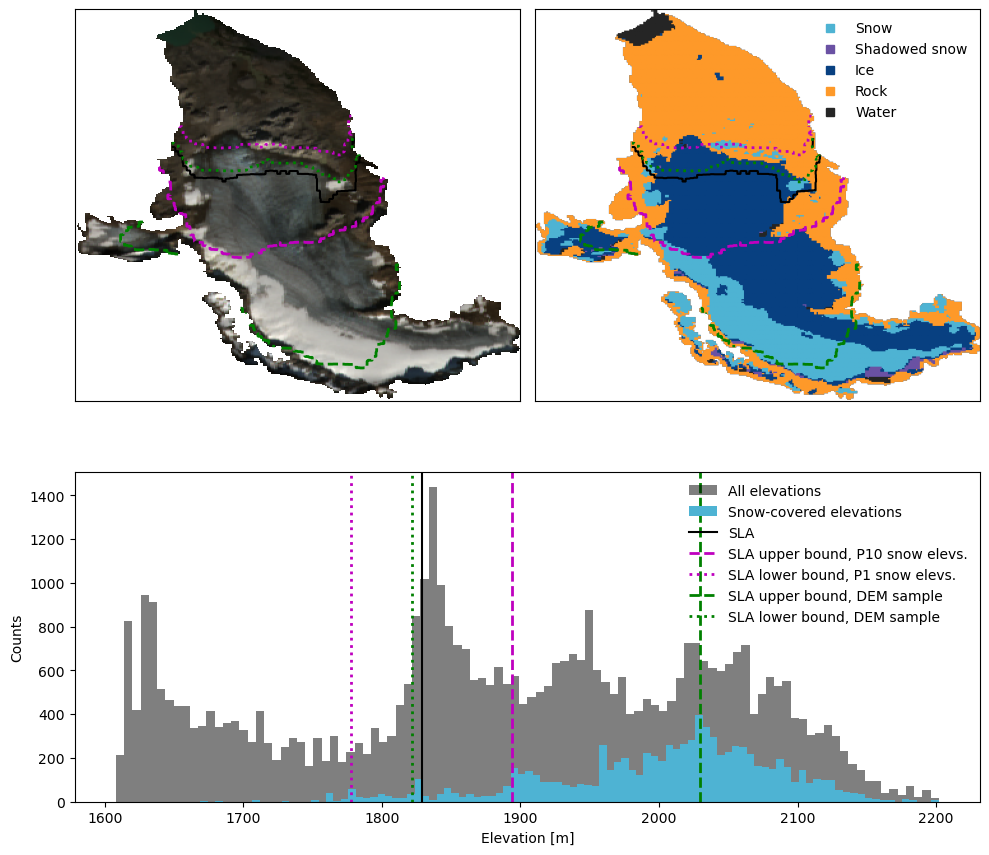

In [3]:
rgi_id = 'RGI2000-v7.0-G-02-14143'

# Near end of season example
get_sla_metrics(
    rgi_id, 
    '2022-09-25', 
    '2022-09-28'
    )


Querying GEE for DEM
No ArcticDEM coverage
Using NASADEM
Querying GEE for Sentinel-2_SR image collection
Classifying image collection
Calculating SLA metrics


Downloading:   0%|          | 0.00/651k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/6.18k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/11.8k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/12.0k [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0174..1.1552].


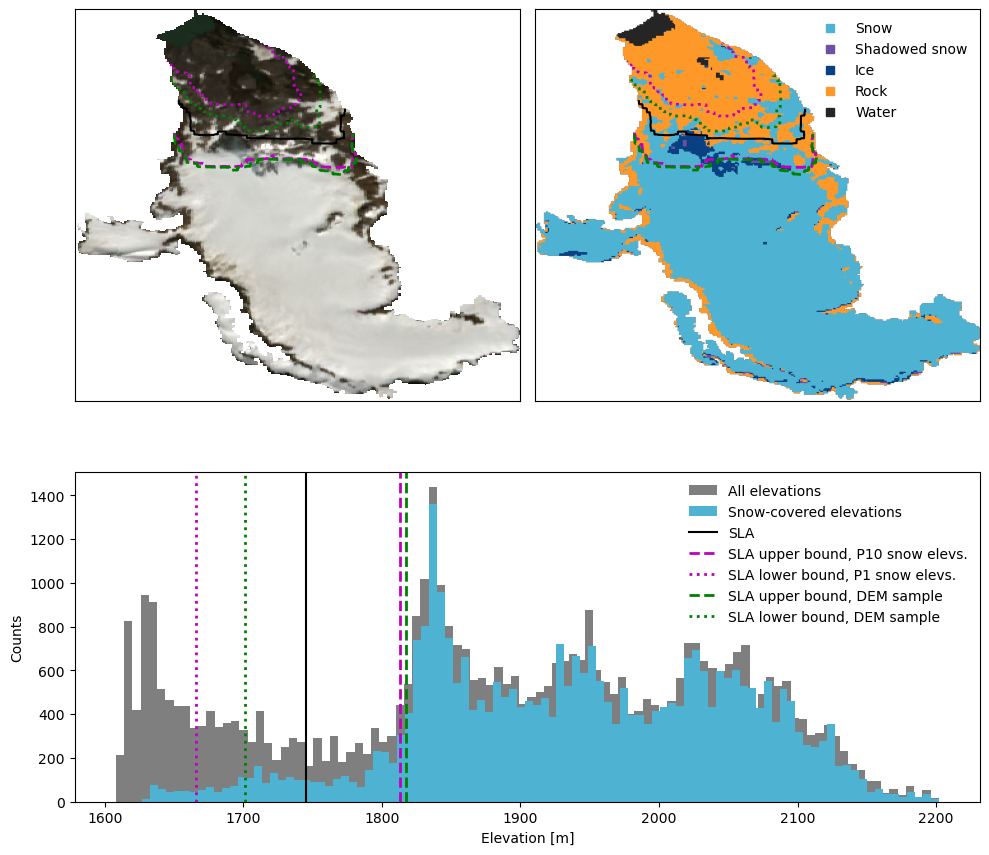

In [4]:
# Earlier season example
get_sla_metrics(
    rgi_id, 
    '2022-07-25', 
    '2022-07-28'
    )


Querying GEE for DEM
No ArcticDEM coverage
Using NASADEM
Querying GEE for Sentinel-2_SR image collection
Classifying image collection
Calculating SLA metrics


Downloading:   0%|          | 0.00/673k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/5.94k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/11.8k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/8.94k [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0324..1.1096].


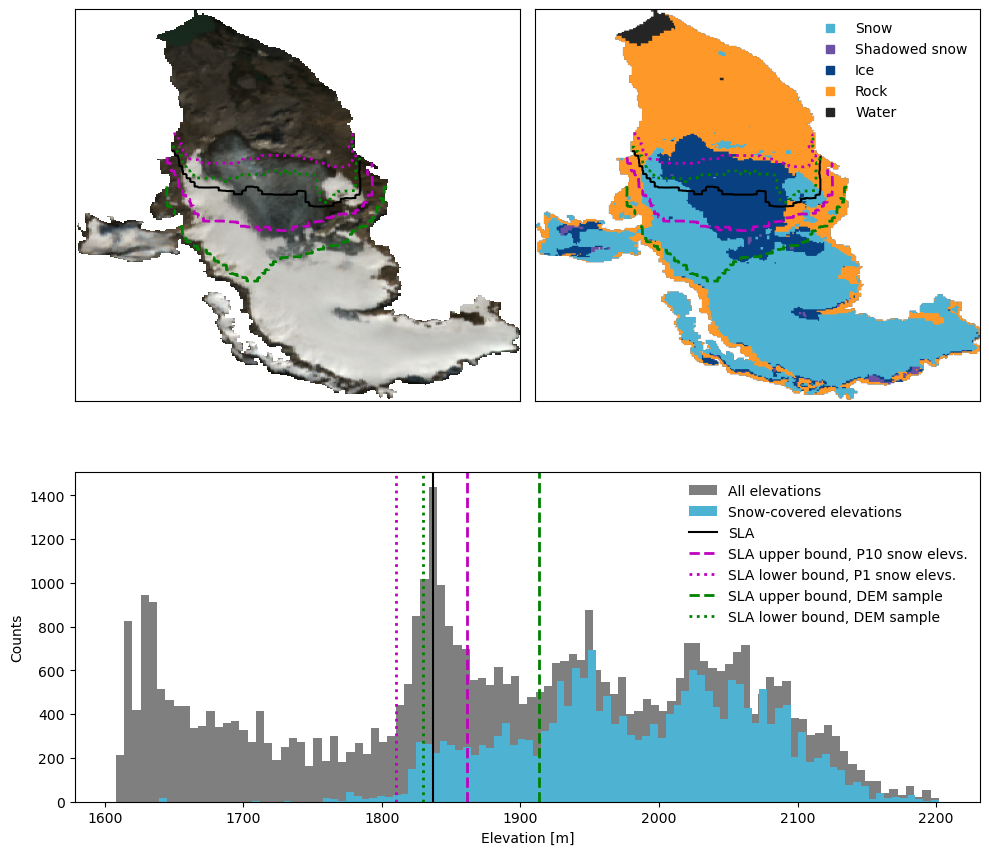

In [5]:
get_sla_metrics(
    rgi_id, 
    '2022-08-25', 
    '2022-08-28'
    )